In [94]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [61]:
class TumorDataset(Dataset):
    def __init__(self, transform = None):
        self.image_paths = []
        self.labels = dict()
        self.transform = transform
        for filename in os.listdir('./brain_tumor_dataset/yes'):
            path = os.path.join('./brain_tumor_dataset/yes', filename)
            self.image_paths.append(path)
            self.labels[path] = 1
        for filename in os.listdir('./brain_tumor_dataset/no'):
            path = os.path.join('./brain_tumor_dataset/no', filename)
            self.image_paths.append(path)
            self.labels[path] = 0

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img = Image.open(img_name).convert('RGB')

        if self.transform:
            img = self.transform(img)
            
        return img, self.labels[img_name]

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.ToTensor()
])

In [66]:
data = TumorDataset(transform)
train_data_size = int(len(data) * .9)
all_train_data, test_data = random_split(data, [train_data_size, len(data) - train_data_size])
train_data_size = int(len(all_train_data) * .7)
train_data, val_data = random_split(all_train_data, [train_data_size, len(all_train_data) - train_data_size])
print(len(train_data), len(val_data), len(test_data))

batch_size = 24
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

158 69 26


In [78]:
lr = 1e-5
epochs = 20

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()

In [95]:
train_loss = []
val_loss = []

for epoch in range(epochs):
    train_loss_local = []
    val_loss_local = []
    model.train()
    for imgs, labels in tqdm(train_dataloader):
        optimizer.zero_grad()
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model.forward(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_local.append(loss.item())

    model.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(val_dataloader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model.forward(imgs)
            loss = loss_fn(outputs, labels)
            val_loss_local.append(loss.item())

    train_loss.append(sum(train_loss_local) / len(train_loss_local))
    val_loss.append(sum(val_loss_local) / len(val_loss_local))

    print(f"Epoch: {epoch}, Train Loss: {train_loss[len(train_loss) - 1]}, Val Loss: {val_loss[len(val_loss) - 1]}")

100%|█████████████████████████████████████████████| 3/3 [00:16<00:00,  5.45s/it]


Epoch: 0, Train Loss: 0.36761922921453205, Val Loss: 0.4560231765111287


100%|█████████████████████████████████████████████| 3/3 [00:11<00:00,  3.97s/it]


Epoch: 1, Train Loss: 0.1660975499876908, Val Loss: 0.40983380873998004


100%|█████████████████████████████████████████████| 3/3 [00:11<00:00,  3.98s/it]


Epoch: 2, Train Loss: 0.20089541375637054, Val Loss: 0.5524451831976572


100%|█████████████████████████████████████████████| 3/3 [00:13<00:00,  4.63s/it]


Epoch: 3, Train Loss: 0.16831533743866853, Val Loss: 0.3947048435608546


100%|█████████████████████████████████████████████| 3/3 [00:11<00:00,  3.83s/it]


Epoch: 4, Train Loss: 0.06575342966243625, Val Loss: 0.26316075834135216


100%|█████████████████████████████████████████████| 3/3 [00:11<00:00,  3.84s/it]


Epoch: 5, Train Loss: 0.00650856047702421, Val Loss: 0.7743599812189738


100%|█████████████████████████████████████████████| 3/3 [00:11<00:00,  3.85s/it]


Epoch: 6, Train Loss: 0.0023162747571145053, Val Loss: 0.5969155615118021


  0%|                                                     | 0/7 [00:16<?, ?it/s]


KeyboardInterrupt: 

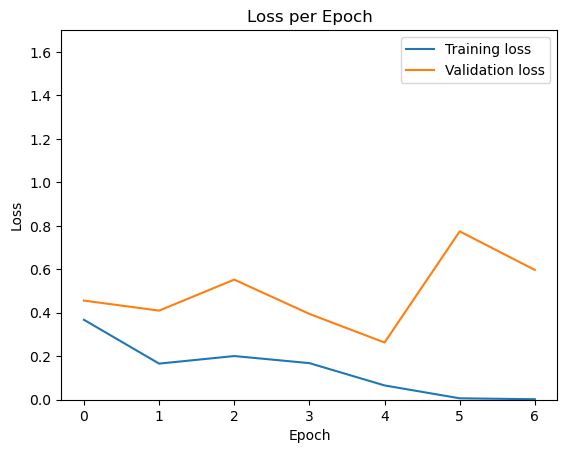

In [96]:
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.7])
plt.show()